In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import sklearn.metrics as metrics

# Where does model p-values come from?

I've always wondered where p-values come from. I knew they would tell me how likely a model coefficient is telling me something about my data, but I never really knew how you get from point a to point b to point p-value. So here I've tried to describe the process for a linear model from nothing to coefficient p-value. I suppose this is basically true for any sort of GLM (like logistic regression, multi-level models, etc.). But in this case I'm doing it for a model with a single independent variable.

## Ordinary Least Squares

I'm not going to repeat all of wikipedia and every machine learning MOOC out there, and try to stick to the basics here. Ordinary least squares is a way to solve a linear model to find the best fitting model. Many modeling systems do this automatically (for e.g., [statsmodels](https://www.statsmodels.org/stable/index.html)). Basically, we want to take this equation:

$$ \hat{y} = \hat{\beta} \hat{X} + b $$

Where $\hat{y}$ is the dependent variable (the thing you want to predict) and $\hat{X}$ are all the variables (i.e., your data) you think might give you some prediction and perhaps explanation of where $\hat{y}$ comes from. Now this is just a model, it fits a plane to your data and suggests that plane explains something about the data or at least gives a prediction for what a given $y_i$ is given a bunch of $X_i$. In order to know what the shape of the plane is supposed to be, we have to know what the $\beta$s are. The way we figure out the best $\beta$s is by minimizing a loss function (i.e., least squares).

$$ L(X) = \sum_{i}^{N} (y_i - p_i)^2 $$

That is, given our actual y value in our data, how far away is our predicted model $\hat{y}$ and then do this for all the data being used to fit the model. Since this is the square error (basically) we want the error to be low because if its high we can't really trust what our model is telling us. So we have to minimize it. One way to minimize something is to take the derivative and set it equal to zero. This is typically done by [solving the normal equations](http://mathworld.wolfram.com/LeastSquaresFitting.html).

So to bring this all down to earth, lets say we have some hypothesis that strong men's maximum deadlift is proportional to their total muscle mass. Let's also assume for argument's sake that we have some way to directly measure the muscle mass of a person and that our data set is controlled for things like height which may impact the total muscle mass.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/05/Arnold_Schwarzenegger_1974.jpg" width=250px />

Text(0.5, 0, 'weight (kg)')

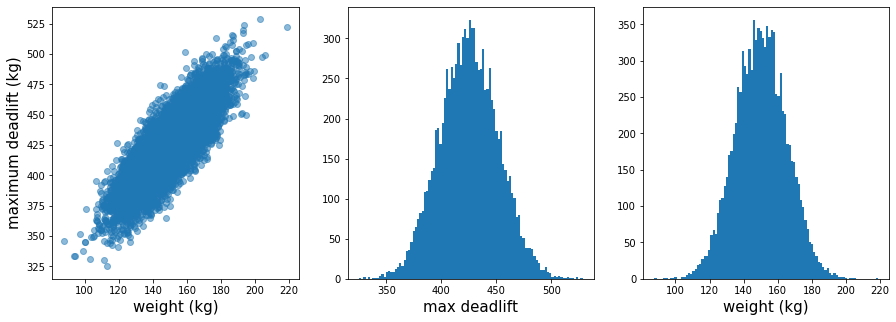

In [2]:
num_samples = 10000

weight_kg = np.random.normal(loc=150, scale=15, size=num_samples)
coef = 1.5
intercept = 200
max_dead_lift = intercept + coef * weight_kg + np.random.normal(loc=0, scale=15, size=num_samples)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(weight_kg, max_dead_lift, alpha=0.5)
ax1.set_ylabel('maximum deadlift (kg)', fontsize=15)
ax1.set_xlabel('weight (kg)', fontsize=15)

ax2.hist(max_dead_lift, bins=100)
ax2.set_xlabel('max deadlift', fontsize=15)

ax3.hist(weight_kg, bins=100)
ax3.set_xlabel('weight (kg)', fontsize=15)
# note: ther aren't a lot of people who are >200kg, however eddie hall, the current record holder of deadlift (at 500kg) did weigh approximately 200kg when he won the record of a 500kg unassisted deadlift. 


So now that we have our fake data concerning strong men and their weights, we can try to fit a model between them iteratively. Given some starting value of the coefficient `beta` of our model:

    max_deadlift ~ beta * weight + intercept
    
So basically we guess what the starting values of `beta` and `intercept` are, then we vary them by some step hoping that it gets better until it stops getting better. One way to guess is to set `beta` and `intercept` to zero and start increasing it (we can fudge a little knowing the relationship is positive from the graph). 

In this case, we probably have the computational power to explore the entire error space but if we had tons of data and this took a lot of time we might not be able to do do a for loop like I've done below and just run a while loop until we've minimized the mean square error enough.

In [3]:
data_df = pd.DataFrame({'weight (kg)':weight_kg, 'max deadlift':max_dead_lift})
train_x, test_x, train_y, test_y = train_test_split(data_df['weight (kg)'], data_df['max deadlift'])

In [4]:
lr = LinearRegression()
lr.fit(train_x.to_frame(), train_y)
lr.score(test_x.to_frame(), test_y)

0.7049642680468985

Text(0.5, 0, 'residuals')

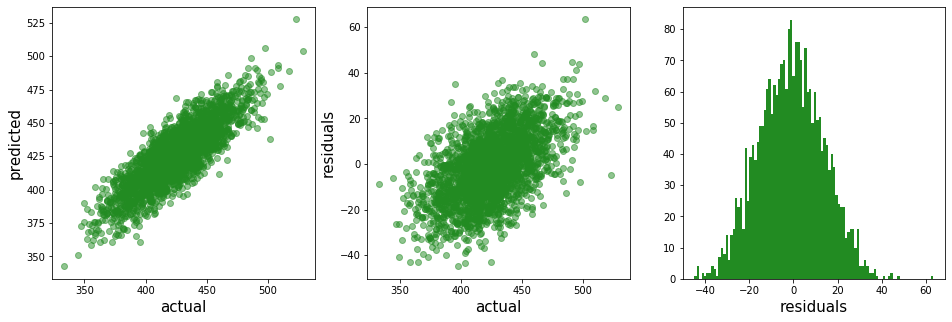

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

predicted = lr.predict(test_x.to_frame())
ax1.scatter(test_y, predicted, alpha=0.5, color='forestgreen')

residuals = test_y - predicted
ax2.scatter(test_y, residuals, alpha=0.5, color='forestgreen')

h = ax3.hist(residuals, bins=100, color='forestgreen')

ax1.set_xlabel('actual', fontsize=15)
ax1.set_ylabel('predicted', fontsize=15)
ax2.set_xlabel('actual', fontsize=15)
ax2.set_ylabel('residuals', fontsize=15)
ax3.set_xlabel('residuals', fontsize=15)

So basically, we have a linear model now that tells us this relationship of weight to max deadlift is probably telling us something about something. However, in order to have more believability of our model, we can perform various tests on the coeficients themselves. For example, we can perform a two tailed t-test between a model where the coefficient in question is 0 or the fitted value **[[citation](http://www.eco.uc3m.es/~ricmora/miccua/materials/DavidsonMacKinnon_2004_Ch4.pdf)]**. We will do this below.

In [6]:
metrics.r2_score(test_y.values.reshape(-1, 1),lr.predict(test_x.to_frame()))

0.7049642680468986

In [7]:
lr.coef_[0]

1.48542865818435

In [8]:
lr.intercept_

202.37964206358194

In [9]:
coefs = np.linspace(lr.coef_[0]-lr.coef_[0], lr.coef_[0]+lr.coef_[0], 100)
intercepts = np.linspace(lr.intercept_-lr.intercept_, lr.intercept_+lr.intercept_, 100)
y_pred = []
for m, b in itertools.product(coefs, intercepts):
    y = m * test_x + b
    y_pred.append((m, b, y))
    
r2s = []
for m, b, y in y_pred:
    r2 = metrics.r2_score(test_y.values.reshape(-1, 1), y)
#     ttest = stats.ttest_ind(y, yzero)
    ttest = stats.ttest_1samp(a=[b, m], popmean=0)
    r2s.append(np.array([m, b, r2, ttest.statistic, ttest.pvalue]))

# ttests = [stats.ttest_ind(y[2], yzero).pvalue for y in y_pred]
# ttests = [stats.ttest_1samp(a=[b,m], popmean=0).pvalue for y in y_pred]

In [10]:
r2_df = pd.DataFrame(np.array(r2s), columns=['coef', 'intercept', 'r2', 'ttest', 't-pval'])
r2_df['log_r2'] = r2_df.r2.apply(lambda r: np.log10(r))
r2_space = r2_df.pivot_table(index='coef', columns='intercept', values='r2')
r2_df.describe()

,coef,intercept,r2,ttest,t-pval,log_r2
count,10000.000000,10000.000000,10000.000000,9999.000000,9999.000000,839.000000
mean,1.485429,202.379642,-41.677373,1.048935,0.488235,-0.555494
std,0.866275,118.024183,49.854654,0.221556,0.030043,0.404321
min,0.000000,0.000000,-248.544122,1.000000,0.099959,-3.551745
25%,0.742714,101.189821,-62.778643,1.006997,0.490930,-0.712910
50%,1.485429,202.379642,-21.253805,1.014490,0.495421,-0.441954
75%,2.228143,303.569463,-4.080537,1.028908,0.497780,-0.272006
max,2.970857,404.759284,0.705567,6.316398,0.500000,-0.151462


Text(0, 0.5, 'R2')

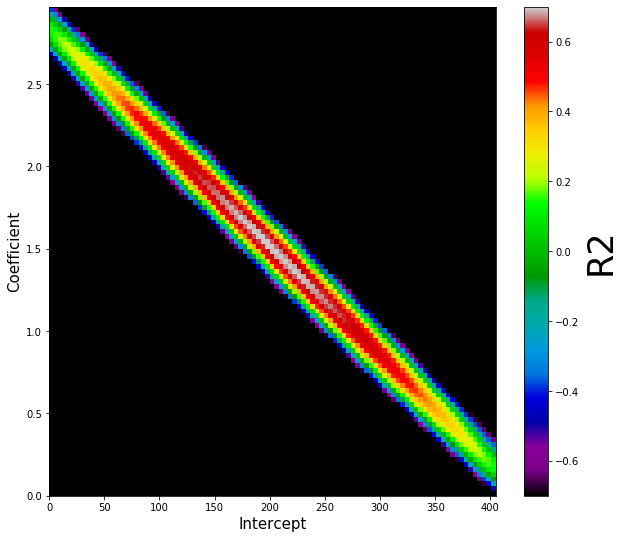

In [11]:
fig, ax = plt.subplots(figsize=(10, 9))
cbar = ax.pcolormesh(r2_space.columns, r2_space.index, r2_space.values, cmap='nipy_spectral', vmin=-0.7, vmax=0.7)
fig.colorbar(cbar)
ax.set_ylabel('Coefficient', fontsize=15)
ax.set_xlabel('Intercept', fontsize=15)
fig.get_axes()[1].set_ylabel('R2', fontsize=35)

Text(0, 0.5, 'p-value')

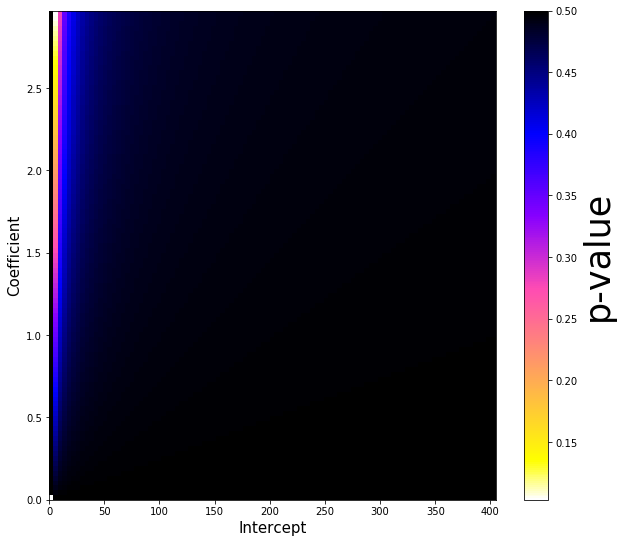

In [12]:
p_space = r2_df.pivot_table(index='coef', columns='intercept', values='t-pval')

fig, ax = plt.subplots(figsize=(10, 9))
cbar = ax.pcolormesh(p_space.columns, p_space.index, p_space.values, cmap='gnuplot2_r')
fig.colorbar(cbar)
ax.set_ylabel('Coefficient', fontsize=15)
ax.set_xlabel('Intercept', fontsize=15)
fig.get_axes()[1].set_ylabel('p-value', fontsize=35)

In [302]:
yzero = 0 * test_x + lr.intercept_

# ttests = [t for t in stats.ttest_ind(y, yzero) for y in ypred]
for y in y_pred:
    stats.ttest_ind(y[2], yzero)
    
ttests = [stats.ttest_ind(y[2], yzero).pvalue for y in y_pred]

In [314]:
len(ttests)

10000

In [200]:
ypred = lr.coef_[0]*test_x + lr.intercept_

In [321]:
stats.ttest_1samp(a=[lr.coef_[0], lr.intercept_], popmean=0)

Ttest_1sampResult(statistic=1.0149501353506452, pvalue=0.49527661903201736)

In [323]:
lr.intercept_

201.09767296963722

In [203]:
import statsmodels.api as sm

In [204]:
sm_train_x = sm.add_constant(train_x)
model = sm.OLS(train_y, sm_train_x)
results = model.fit()
results.summary()

/home/john/anaconda3/envs/research/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           max deadlift   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                 1.655e+04
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:31:00   Log-Likelihood:                -30936.
No. Observations:                7500   AIC:                         6.188e+04
Df Residuals:                    7498   BIC:                         6.189e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         201.0977      1.745    115.222      0.000     197.676     204.519
weight (kg)     1.4921      0.012    128.665      0.000       1.469       1.515
==============================================================================
Omnibus:                        1.030   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                0.989
Skew:                           0.014   Prob(JB):                        0.610
Kurtosis:                       3.049   Cond. No.                     1.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

const          201.097673
weight (kg)      1.492065
dtype: float64

## However the calculated t-statistics completely disagrees with the calculated t-statistic from statsmodels. . .